In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
from matplotlib import font_manager

for font in font_manager.fontManager.ttflist:
    if 'lim' in font.name:
        print(font.name, font.fname)

New Gulim C:\Windows\Fonts\NGULIM.TTF
Gulim C:\Windows\Fonts\gulim.ttc


In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

matplotlib.rc('font', family='New Gulim')
plt.rcParams['axes.unicode_minus'] = False

import numpy as np
np.random.seed(100)

In [4]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"

## 데이터 불러오기

In [5]:
from sklearn.datasets import fetch_openml

In [6]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int)

In [7]:
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

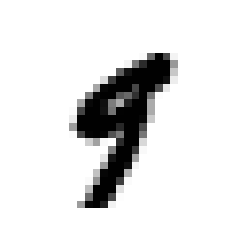

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X.iloc[36000]
some_digit_image = some_digit.values.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

plt.show()

In [10]:
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

In [11]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train.iloc[shuffle_index], y_train.iloc[shuffle_index]

In [12]:
y_train_9 = (y_train == 5)
y_test_9 = (y_test == 5)

### 확률적 경사 하강법으로 이진 분류기 훈련

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 5, random_state=100)
sgd_clf.fit(X_train, y_train_9)

SGDClassifier(max_iter=5, random_state=100)

In [14]:
sgd_clf.predict([some_digit])

array([False])

### 정확도 측정

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_9, cv = 3, scoring = 'accuracy')

array([0.96255, 0.96345, 0.9572 ])

#### '9' 아님 클래스로 분류하는 더미분류기

In [16]:
from sklearn.base import BaseEstimator

class Never9Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_9_clf = Never9Classifier()
cross_val_score(never_9_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.9107 , 0.9093 , 0.90895])

 --> 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌

불균형한 데이터셋을 다룰때 더욱 그러하다

## 오차행렬 - 분류기의 성능을 평가하는 방법

클래스 a의 샘플이 클래스 b로 분류된 횟수를 센다

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_9, cv = 3)

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_9, y_train_pred)

array([[53504,  1075],
       [ 1261,  4160]], dtype=int64)

### 행 : 실제 클래스 
### 열 : 예측한 클래스

#### 오차행렬 검색해서 이미지 활용

## 정밀도와 재현율

In [20]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_9, y_train_pred)

0.7946513849092646

In [21]:
recall_score(y_train_9, y_train_pred)

0.7673860911270983

### 정밀도와 재현율을 f1점수라는 하나의 숫자로 만듦 : 정밀도와 재현율의 조화평균

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_9, y_train_pred)

0.7807807807807808

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-61974.23804473])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
# threshold = 200000
# y_some_digit_pred = (y_scores > threshold)
# y_some_digit_pred

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9, cv = 3,
                             method = 'decision_function')

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

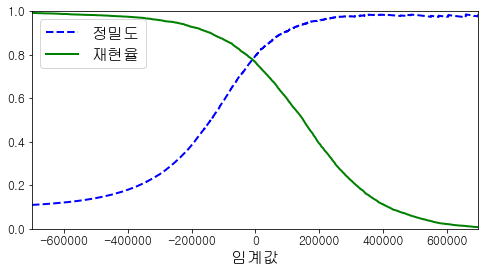

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

### ROC 곡선

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

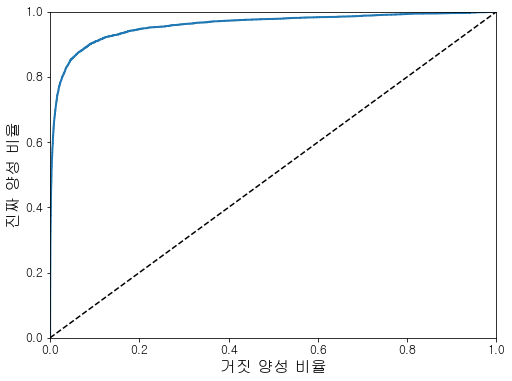

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('거짓 양성 비율', fontsize=16)
    plt.ylabel('진짜 양성 비율', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

#### 곡선 아래 면적 (AUC) area under the curve

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_9, y_scores)

0.9587687793860062

### RandomForestClassifier을 훈련시켜 SGDClassfier의 ROC곡선과 ROC AUC 점수 비교

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators = 10, random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv = 3,
                                   method = 'predict_proba')

In [36]:
y_score_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9, y_score_forest)

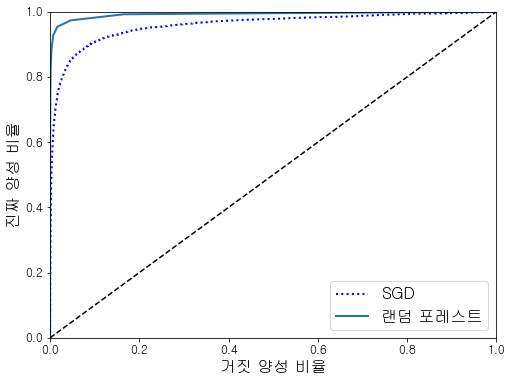

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [39]:
roc_auc_score(y_train_9, y_score_forest)

0.9918737517163586

## 다중분류

##### 일대다 전략(One-verse-All) OvA

특정 숫자 하나만 구분하는 숫자별 이진분류기 10개(0부터 9까지)를 훈련시켜

클래스가 10개인 숫자 이미지 분류 시스템 만들기 가능

이미지 분류할 때마다 각 분류기의 결정점수 중에서 가장 높은것을 클래스로 선택

이진분류 알고리즘에서 선호

##### 일대일 전략(One  verse One) OvO

0과 1 구분, 0과 2 구분, 1과 2 구분 등과 같이 각 숫자의 조합마다 이진분류기를 훈련시키는 것

클래스가 N개라면 분류기는 N x (N - 1)/2개 필요

장점 :  각 분류기의 훈련에 전체 훈련세트 중 구별할 두 클래스에 해당하는 샘플만 필요

일부 알고리즘은 훈련세트의 크기에 민감해서 큰 훈련세트에서 몇개의 분류기를 훈련시키는 것 보다 작은 훈련세트에서 많은 분류기를 훈련시키는 쪽이 빠름 -> OvO  이용

### SGDClassifier 적용

In [41]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([9])

9를 구별한 타깃 클래스(y_train_9) 대신 0에서 9까지의 원래 타깃 클래스(y_train)을 사용하여 SGDClassifier을 훈련시킴

In [42]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-739056.26253872, -481051.57270388, -725649.15159271,
        -188112.80912834, -129359.18152495, -374727.80578794,
        -673792.90866705, -339015.8400753 , -360832.3818591 ,
         -67854.07450583]])

클래스마다 하나씩 총 10개의 점수 반환

In [43]:
np.argmax(some_digit_scores)

9

In [44]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [47]:
sgd_clf.classes_[9]

9

In [48]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([9])

In [49]:
len(ovo_clf.estimators_)

45

#### RandomForestClassifier을 훈련시킴

In [51]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([9])

In [52]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0.9]])

10번째 값인 0.9는 이 이미지가 9일 가능성을 90%로 추정한다는 뜻

#### SGDClassifier의 정확도 예측 - cross_val_score()

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.87545, 0.80985, 0.8706 ])

#### 입력의 스케일 조정

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.9088 , 0.91125, 0.908  ])

## 에러 분석

In [55]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5732,    2,   21,   11,   12,   48,   42,    9,   42,    4],
       [   1, 6471,   49,   23,    6,   37,    5,   10,  129,   11],
       [  53,   37, 5363,   78,   74,   32,   80,   64,  162,   15],
       [  50,   46,  146, 5311,    1,  248,   38,   61,  137,   93],
       [  20,   25,   42,   10, 5357,    7,   50,   35,   83,  213],
       [  69,   39,   40,  181,   74, 4624,   93,   30,  178,   93],
       [  33,   29,   56,    2,   44,  102, 5589,    6,   57,    0],
       [  24,   18,   76,   26,   62,   10,    5, 5793,   16,  235],
       [  50,  139,   79,  145,   13,  159,   57,   26, 5042,  141],
       [  41,   38,   26,   84,  151,   33,    2,  213,   82, 5279]],
      dtype=int64)

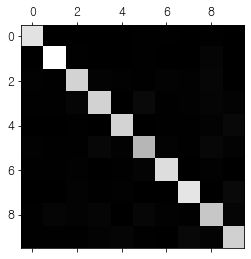

In [56]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

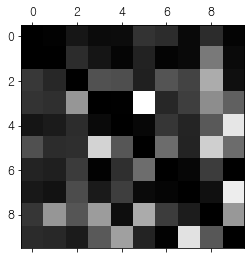

In [59]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

행은 실제 클래스 열은 예측한 클래스

밝음 -> 많은 이미지가 5로 잘못 분류되었음

클래스 1의 열은 매우 어두움 -> 숫자 1이 정확하게 분류됨

--> 5 4 혼돈 보완 및 8 9 분류 필요

## 다중 레이블 분류

In [67]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [68]:
knn_clf.predict([some_digit])

array([[ True,  True]])

## 다중 출력 분류

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한 것

In [69]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [70]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [76]:
def plot_digit(data):
    image = data.values.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

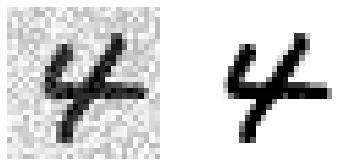

In [78]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod.iloc[some_index])
plt.subplot(122); plot_digit(y_test_mod.iloc[some_index])
plt.show()

In [81]:
def plot_digit2(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

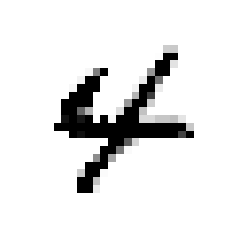

In [82]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index]])
plot_digit2(clean_digit)

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")